In [1]:
import pandas as pd
import numpy as np
from recommender_metrics.plots import LongTailPlot
from recommender_metrics.metrics import mark, coverage, diversity, serendipity

# MovieLense Dataset
Using the MovieLens 20M Dataset dataset for examples. You can download this data here: https://grouplens.org/datasets/movielens/20m/

In [2]:
ratings = pd.read_csv('../movie_similarity_flask_api/data/ml-20m/ratings.csv')
ratings = ratings.query('rating >=3')
ratings.reset_index(drop=True, inplace=True)

In [3]:
#only consider ratings from users who have rated over 1000 movies
users = ratings.userId.value_counts()
users = users[users>1000].index.tolist()

In [4]:
ratings = ratings.query('userId in @users')
print ratings.shape
ratings.head(3)

(1317902, 4)


,userId,movieId,rating,timestamp
15918,156,1,5.0,1037739266
15919,156,2,5.0,1040937649
15920,156,4,3.0,1038801803


# Long Tail Plot Example

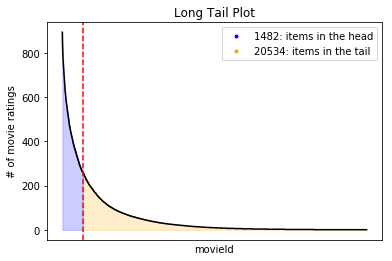

In [5]:
LongTailPlot(df=ratings, 
             item_id_column="movieId", 
             interaction_type="movie ratings", 
             percentage=0.5,
             x_labels=False)

# Simple Popularity Recommender
Creating a simple popularity recommender to demonstrate recommender metrics in action. The popularity recommender simply recommends the top 10 movies to every user.

## test/train split

In [6]:
# the test data contains 10 movies from each user that are rated greater than 3 stars
test_index = ratings.copy()
test_index = test_index.groupby('userId')
test_index = test_index.apply(lambda x: x.sample(min(10, len(x))))

test_index.drop(axis=1, columns="userId", inplace=True)
test_index.reset_index(inplace=True, drop=False)
test_index = test_index.level_1.values.tolist()

test = ratings.loc[test_index]
test = test.copy().groupby('userId')['movieId'].agg({'actual': (lambda x: list(set(x)))})
test.head()

/Users/clairelongo/Documents/Work/prof_dev/recommender_metrics/venv/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()


,actual
userId,
156,"[1344, 161, 3654, 4337, 5196, 2289, 2105, 3519..."
208,"[1280, 800, 930, 2275, 854, 32914, 246, 107771..."
359,"[6149, 41863, 7373, 7502, 3727, 5293, 2078, 33..."
394,"[2731, 4190, 910, 7153, 4979, 33493, 342, 7095..."
572,"[4929, 49347, 46948, 2918, 1777, 3474, 788, 71..."


In [7]:
train = ratings[~ratings.index.isin(test_index)].dropna()
train.head()

,userId,movieId,rating,timestamp
15918,156,1,5.0,1037739266
15919,156,2,5.0,1040937649
15920,156,4,3.0,1038801803
15921,156,5,3.0,1040944583
15922,156,6,4.0,1037822117


## Popularity Recommendations

In [8]:
#make popularity recommendations for all members in the test data
popularity_recs = train.movieId.value_counts().head(10).index.tolist()

recs = []
for user in test.index.tolist():
    predictions = popularity_recs
    recs.append(predictions)
        
test['predicted'] = recs
test.head()

,actual,predicted
userId,,
156,"[1344, 161, 3654, 4337, 5196, 2289, 2105, 3519...","[1198, 1270, 593, 318, 2762, 2571, 260, 608, 2..."
208,"[1280, 800, 930, 2275, 854, 32914, 246, 107771...","[1198, 1270, 593, 318, 2762, 2571, 260, 608, 2..."
359,"[6149, 41863, 7373, 7502, 3727, 5293, 2078, 33...","[1198, 1270, 593, 318, 2762, 2571, 260, 608, 2..."
394,"[2731, 4190, 910, 7153, 4979, 33493, 342, 7095...","[1198, 1270, 593, 318, 2762, 2571, 260, 608, 2..."
572,"[4929, 49347, 46948, 2918, 1777, 3474, 788, 71...","[1198, 1270, 593, 318, 2762, 2571, 260, 608, 2..."


In [9]:
actual = test.actual.values.tolist()
predicted = test.predicted.values.tolist()

## Recall

Mar@k for k = 10

In [10]:
mark(actual, predicted, k=10)

0.0023086476462682247

mar@k for k 1 through 10

In [11]:
mark(actual, predicted, k=10)

mar_at_k = []
for K in np.arange(1, 11):
    mar_at_k.extend([mark(actual, predicted, k=K)])
mar_at_k

[0.0010718113612004287,
 0.0013933547695605577,
 0.001714898177920686,
 0.0017684887459807075,
 0.0018971061093247588,
 0.0019864237227581283,
 0.0020323584953810033,
 0.0020859490634410247,
 0.0021693121693121694,
 0.0023086476462682247]

## Coverage

In [12]:
catalog = train.movieId.unique().tolist()
coverage(predicted, catalog)

0.05

## Diveristy

## Serendipity